## Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
# import plotly.express as px

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv


In [3]:
# sample_df = pd.read_csv(r"/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv")
# sample_df

In [4]:
train_df = pd.read_csv("/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv")
train_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,1.0,4.769377,0.0,1.0,18.00,2.5,0.0


In [5]:
payment_type = train_df['payment_type']

In [6]:
train_df['tpep_pickup_datetime'].max(), train_df['tpep_pickup_datetime'].min() 

('2023-07-01 00:58:11', '2023-06-28 15:26:39')

In [7]:
train_df.shape

(175000, 17)

In [8]:
test_df = pd.read_csv("/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv")
test_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee
0,1,2023-06-29 00:21:20,2023-06-29 00:25:20,1.0,4.95,1.0,N,20,3,Credit Card,1.0,6.067612,0.0,1.0,2.5,0.0
1,1,2023-06-30 17:44:43,2023-06-30 17:53:13,1.0,2.10,1.0,N,9,81,Credit Card,2.5,6.191269,0.0,1.0,2.5,0.0
2,1,2023-06-29 18:17:04,2023-06-29 19:23:48,1.0,0.95,1.0,N,92,90,Cash,2.5,3.983872,0.0,1.0,2.5,0.0
3,0,2023-06-30 21:33:53,2023-06-30 21:46:20,1.0,0.80,1.0,N,19,102,Credit Card,3.5,6.839341,0.0,1.0,2.5,0.0
4,1,2023-06-29 14:53:54,2023-06-29 15:22:17,1.0,4.01,1.0,N,131,229,Cash,0.0,1.468943,0.0,1.0,0.0,0.0


In [9]:
test_df.shape

(50000, 16)

## EDA

In [10]:
train_df.isna().sum()

VendorID                    0
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          6077
trip_distance               0
RatecodeID               6077
store_and_fwd_flag       6077
PULocationID                0
DOLocationID                0
payment_type                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge     6077
Airport_fee              6077
dtype: int64

In [11]:
train_df.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type              object
extra                    float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
Airport_fee              float64
dtype: object

In [12]:
train_df.nunique()
unique_values_per_column = train_df.apply(lambda x: x.unique())
unique_values_per_column

VendorID                                                         [1, 0, 2]
tpep_pickup_datetime     [2023-06-28 17:20:21, 2023-06-29 23:05:01, 202...
tpep_dropoff_datetime    [2023-06-28 16:34:45, 2023-06-29 22:01:35, 202...
passenger_count          [1.0, 3.0, 0.0, 2.0, nan, 4.0, 6.0, 5.0, 8.0, ...
trip_distance            [2.14, 2.7, 1.15, 0.4, 1.1, 0.0, 1.33, 0.45, 3...
RatecodeID                            [1.0, 99.0, 3.0, nan, 2.0, 5.0, 4.0]
store_and_fwd_flag                                             [N, nan, Y]
PULocationID             [120, 15, 167, 128, 203, 225, 214, 176, 196, 1...
DOLocationID             [9, 215, 223, 239, 52, 256, 240, 227, 139, 196...
payment_type                     [Credit Card, Cash, Wallet, UPI, unknown]
extra                    [2.5, 3.5, 0.0, 1.0, 9.25, 7.5, 5.0, 4.25, 6.7...
tip_amount               [7.165588608107633, 6.067400799595124, 4.11154...
tolls_amount             [0.0, 6.55, 29.0, 12.75, 15.8, -6.55, 21.75, 2...
improvement_surcharge    

In [13]:
train_df[['tpep_pickup_datetime','tpep_dropoff_datetime']] = train_df[['tpep_pickup_datetime','tpep_dropoff_datetime']].apply(pd.to_datetime)
test_df[['tpep_pickup_datetime','tpep_dropoff_datetime']] = test_df[['tpep_pickup_datetime','tpep_dropoff_datetime']].apply(pd.to_datetime)
train_df['trip_time'] = (train_df['tpep_dropoff_datetime'] - train_df['tpep_pickup_datetime']).dt.total_seconds() / 60
test_df['trip_time'] = (test_df['tpep_dropoff_datetime'] - test_df['tpep_pickup_datetime']).dt.total_seconds() / 60

### Correlation between features

In [14]:
numeric_columns = train_df.select_dtypes(include=['int', 'float'])

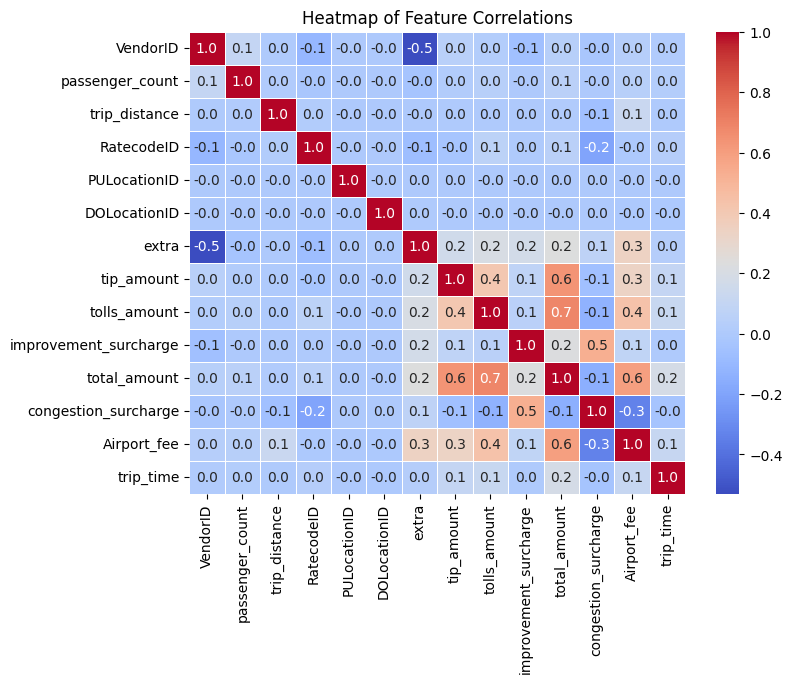

In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm', linewidths=.5, fmt='.1f')

# Adding title
plt.title('Heatmap of Feature Correlations')

# Show the plot
plt.show()

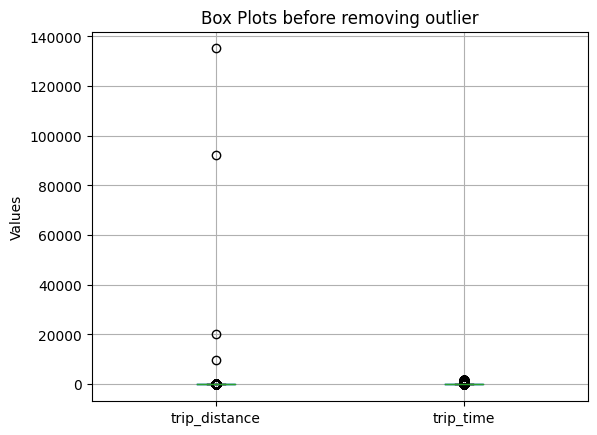

In [16]:
# Select columns for which you want to create box plots
selected_columns = ['trip_distance', 'trip_time']

# Plot box plots for the selected columns
train_df[selected_columns].boxplot()
plt.title('Box Plots before removing outlier')
plt.ylabel('Values')

# Show the box plots
plt.show()

In [17]:
#Replacing outlier value with the median value
index = train_df['trip_distance'].nlargest(4).index
for i in index:
    train_df.loc[i, 'trip_distance'] = train_df['trip_distance'].median()

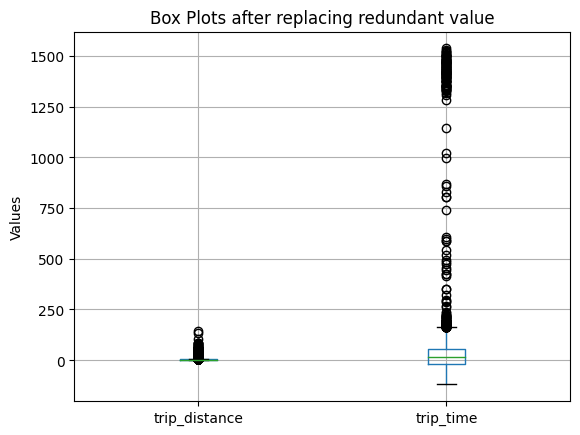

In [18]:
# Select columns for which you want to create box plots
selected_columns = ['trip_distance', 'trip_time']

# Plot box plots for the selected columns
train_df[selected_columns].boxplot()
plt.title('Box Plots after replacing redundant value')
plt.ylabel('Values')

# Show the box plots
plt.show()

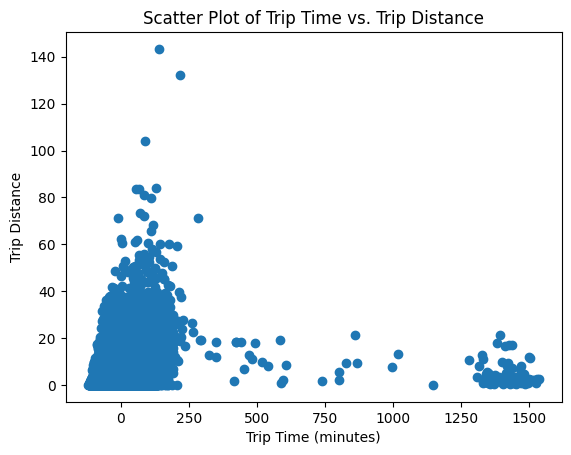

In [19]:
plt.scatter(x=train_df['trip_time'], y=train_df['trip_distance'])

# Adding labels and title
plt.title('Scatter Plot of Trip Time vs. Trip Distance')
plt.xlabel('Trip Time (minutes)')
plt.ylabel('Trip Distance')

# Show the plot
plt.show()

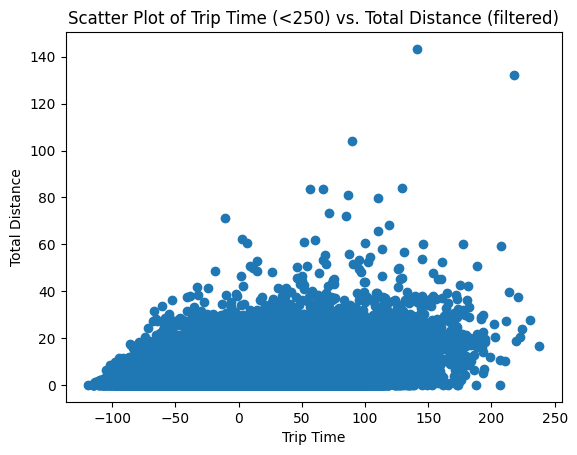

In [20]:
plt.scatter(x=train_df['trip_time'][train_df['trip_time'] < 250],
            y=train_df['trip_distance'][train_df['trip_time'] < 250])

# Adding labels and title for 'trip_distance'
plt.title('Scatter Plot of Trip Time (<250) vs. Total Distance (filtered)')
plt.xlabel('Trip Time')
plt.ylabel('Total Distance')

# Show the plot for 'trip_distance'
plt.show()

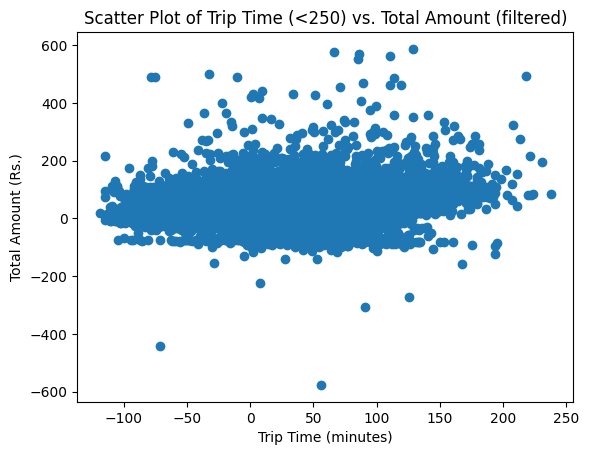

In [21]:
plt.scatter(x=train_df['trip_time'][train_df['trip_time'] < 250],
            y=train_df['total_amount'][train_df['trip_time'] < 250])

# Adding labels and title
plt.title('Scatter Plot of Trip Time (<250) vs. Total Amount (filtered)')
plt.xlabel('Trip Time (minutes)')
plt.ylabel('Total Amount (Rs.)')

# Show the plot
plt.show()

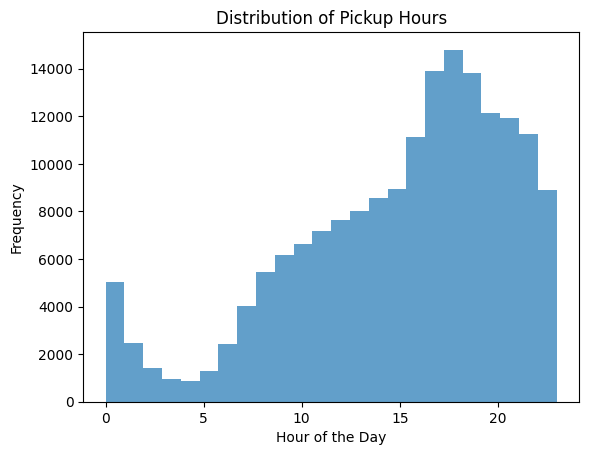

In [22]:
train_df['pickup_hour'] = train_df['tpep_pickup_datetime'].dt.hour
test_df['pickup_hour'] = test_df['tpep_pickup_datetime'].dt.hour
# Create a histogram
plt.hist(train_df['pickup_hour'], bins=24, alpha=0.7)

# Adding labels and title
plt.title('Distribution of Pickup Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')

# Show the plot
plt.show()

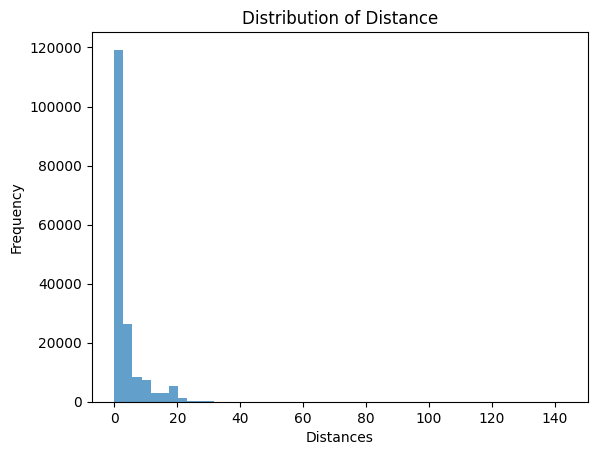

In [23]:
distance = train_df['trip_distance']

# Create a histogram
plt.hist(distance, bins=50, alpha=0.7)

# Adding labels and title
plt.title('Distribution of Distance')
plt.xlabel('Distances')
plt.ylabel('Frequency')

# Show the plot
plt.show()

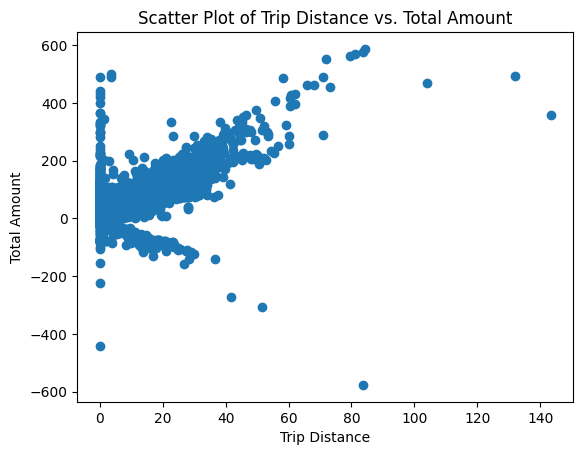

In [24]:
plt.scatter(x=train_df['trip_distance'], y=train_df['total_amount'])

# Adding labels and title
plt.title('Scatter Plot of Trip Distance vs. Total Amount')
plt.xlabel('Trip Distance')
plt.ylabel('Total Amount')

# Show the plot
plt.show()

In [25]:
train_df[(train_df['trip_time']>-5) & (train_df['trip_time']<5)].shape

(12647, 19)

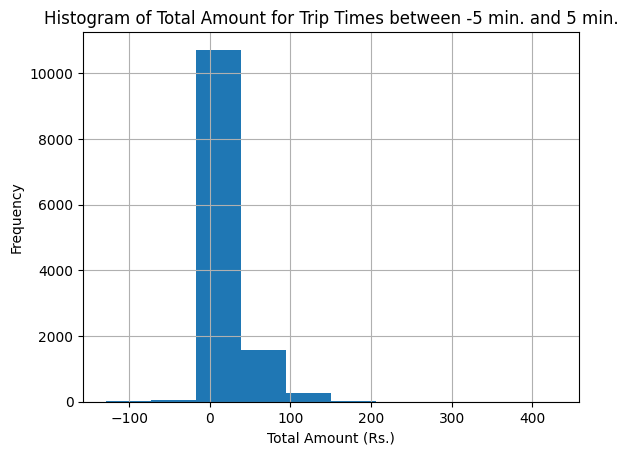

In [26]:
train_df[(train_df['trip_time'] > -5) & (train_df['trip_time'] < 5)]['total_amount'].hist()

# Adding labels and title
plt.title('Histogram of Total Amount for Trip Times between -5 min. and 5 min.')
plt.xlabel('Total Amount (Rs.)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [27]:
hist_data = pd.DataFrame(train_df['passenger_count'].value_counts().reset_index())
hist_data

,passenger_count,count
0,1.0,128534
1,2.0,24316
2,3.0,6018
3,4.0,3668
4,0.0,2818
5,5.0,1970
6,6.0,1596
7,8.0,2
8,9.0,1


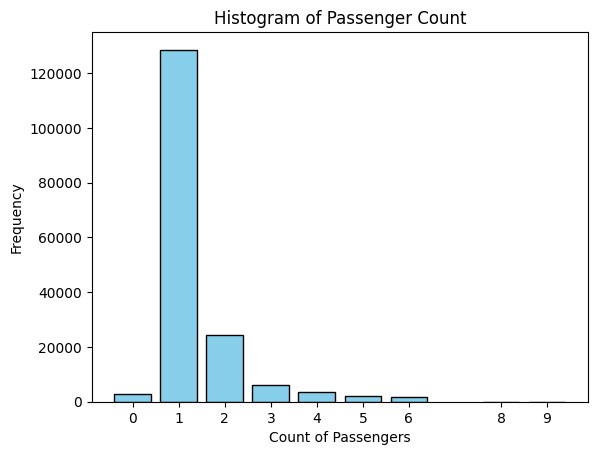

In [28]:
# Plot the histogram
plt.bar(hist_data['passenger_count'], hist_data['count'], color='skyblue', edgecolor='black')
plt.xlabel('Count of Passengers')
plt.xticks(hist_data['passenger_count'])
plt.ylabel('Frequency')
plt.title('Histogram of Passenger Count')
plt.show()

In [29]:
train_df[train_df['passenger_count']==0].shape

(2818, 19)

In [30]:
test_df[test_df['passenger_count']==0].shape

(781, 18)

In [31]:
train_df[train_df['passenger_count'].isna()].head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,trip_time,pickup_hour
33,1,2023-06-29 23:59:24,2023-06-29 23:10:40,NaN,2.80,NaN,NaN,216,21,Wallet,0.0,6.076642,0.00,1.0,26.93,NaN,NaN,-48.733333,23
53,1,2023-06-30 02:43:08,2023-06-30 03:44:22,NaN,18.98,NaN,NaN,72,263,Wallet,0.0,11.588252,12.75,1.0,83.24,NaN,NaN,61.233333,2
56,1,2023-06-30 22:28:53,2023-06-30 23:33:12,NaN,1.36,NaN,NaN,116,128,Wallet,0.0,4.932110,0.00,1.0,20.69,NaN,NaN,64.316667,22
120,0,2023-06-28 22:24:34,2023-06-28 21:57:57,NaN,1.30,NaN,NaN,183,191,Wallet,1.0,5.138688,0.00,1.0,17.25,NaN,NaN,-26.616667,22
127,0,2023-06-28 21:19:33,2023-06-28 22:56:28,NaN,0.00,NaN,NaN,8,40,Wallet,0.0,1.613173,0.00,1.0,34.11,NaN,NaN,96.916667,21


payment_type
Credit Card    135257
Cash            30141
Wallet           6077
unknown          2333
UPI              1192
Name: count, dtype: int64


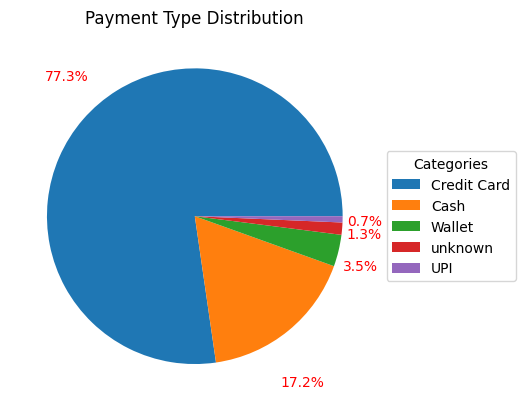

In [32]:
# Count the occurrences of each nominal category
nominal_counts = train_df['payment_type'].value_counts()
print(nominal_counts)
percentage_distribution = (nominal_counts / nominal_counts.sum()) * 100
# Create a pie chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    nominal_counts,
    autopct='%1.1f%%',
    startangle=0,
    textprops=dict(color="r"),  # Set text color to white
)
for i, (wedge, autotext) in enumerate(zip(wedges, autotexts)):
    angle = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
    x = 1.15 * np.cos(np.radians(angle))
    y = 1.45 * np.sin(np.radians(angle))
    autotext.set_position((x, y))
    autotext.set_text(f'{percentage_distribution[i]:.1f}%')

# Add a legend to the plot
plt.legend(nominal_counts.index, title='Categories', loc='center left', bbox_to_anchor=(1, 0.5))

# Add title to the plot
plt.title('Payment Type Distribution')
# Show the pie chart
plt.show()

In [33]:
columns = ['passenger_count', 'congestion_surcharge', 'Airport_fee']
for column in columns:
    train_df[column] = train_df[column].fillna(train_df[column].mode()[0])
    test_df[column] = test_df[column].fillna(test_df[column].mode()[0])

In [34]:
train_df.isna().sum()

VendorID                    0
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count             0
trip_distance               0
RatecodeID               6077
store_and_fwd_flag       6077
PULocationID                0
DOLocationID                0
payment_type                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge        0
Airport_fee                 0
trip_time                   0
pickup_hour                 0
dtype: int64

In [35]:
# column_to_replace = ['tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', 'extra']
# for column in column_to_replace:
#     train_df[column] = train_df[column].apply(lambda x: abs(x) if x < 0 else x)
#     test_df[column] = test_df[column].apply(lambda x: abs(x) if x < 0 else x)
# train_df['total_amount'] = train_df['total_amount'].apply(lambda x: abs(x) if x < 0 else x)

In [36]:
train_df['RatecodeID'] = train_df['RatecodeID'].replace(99, train_df['RatecodeID'].mode().iloc[0])
train_df['RatecodeID'].unique()

array([ 1.,  3., nan,  2.,  5.,  4.])

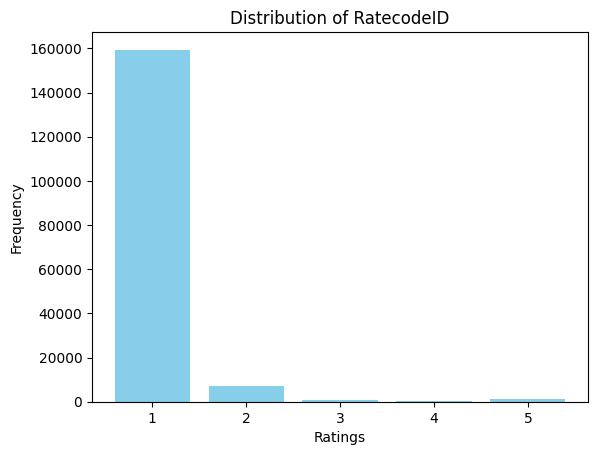

In [37]:
ordinal_counts = train_df['RatecodeID'].value_counts().sort_index()

# Create a bar chart
plt.bar(ordinal_counts.index, ordinal_counts, color='skyblue')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of RatecodeID')
plt.show()

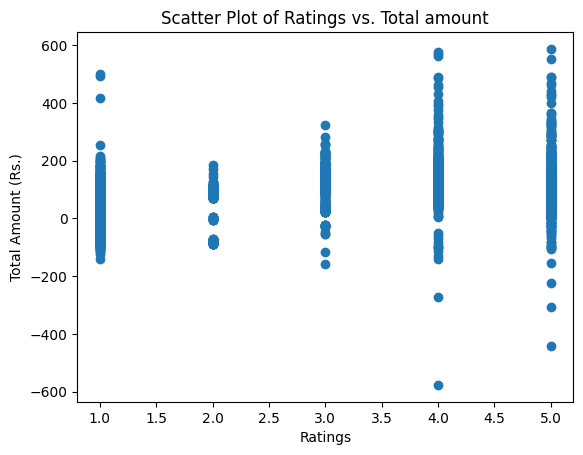

In [38]:
plt.scatter(x=train_df['RatecodeID'], y=train_df['total_amount'])

# Adding labels and title
plt.title('Scatter Plot of Ratings vs. Total amount')
plt.xlabel('Ratings')
plt.ylabel('Total Amount (Rs.)')

# Show the plot
plt.show()

In [39]:
columns_to_drop = ['VendorID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'trip_time', 'RatecodeID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime']
train_df = train_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)

In [40]:
test_df.isna().sum()

passenger_count          0
trip_distance            0
payment_type             0
extra                    0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
congestion_surcharge     0
Airport_fee              0
pickup_hour              0
dtype: int64

## Preprocessing

In [41]:
label_encoder = LabelEncoder()
train_df['payment_type'] = label_encoder.fit_transform(train_df['payment_type'])
test_df['payment_type'] = label_encoder.transform(test_df['payment_type'])

## Specify features and target variable

In [42]:
# Specify the features (X) and target variable (y)
X = train_df.drop(['total_amount'], axis=1)
y = train_df['total_amount']

## Linear regression

In [43]:
# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X, y)

# Make predictions on the testing data
y_pred = model.predict(X)

In [44]:
# Calculate R^2 score
r2_linear = r2_score(y, y_pred)
r2_linear

0.8591733572500986

In [45]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# param_grid = {
#     'alpha': [0.001, 0.01, 0.1, 1, 10, 100]  # Regularization strength
# }
# ridge_model = Ridge()

# # Create the GridSearchCV object
# grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='r2')

# # Fit the model to the training data
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_

# # Get the best Ridge model
# best_ridge_model = grid_search.best_estimator_

# print(f'Best hyperparameters: {best_params}')

# ridge_model.fit(X, y)

In [46]:
# ridge_model = Ridge(alpha=0.001, fit_intercept=True)
# ridge_model.fit(X, y)

# l_pred = ridge_model.predict(X)

# r2 = r2_score(y,l_pred)

## Decision tree regressor

In [47]:
tree_model = DecisionTreeRegressor(max_depth=25, min_samples_leaf=4, min_samples_split=2)

# Fit the model on the training data
# tree_model.fit(X, y)

# Make predictions on the testing data
# y_pred_tree = tree_model.predict(test_df)

# Calculate R^2 score on the testing data
# r2_tree = r2_score(y, y_pred_tree)

# # Display the R^2 score
# print(f'R^2 Score (Decision Tree): {r2_tree}')

In [48]:
# param_grid = {
#     'max_depth': [None, 5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Perform GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(tree_model, param_grid, cv=5, scoring='r2')
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameter values
# best_params = grid_search.best_params_

# # Fit the model with the best hyperparameters on the training data
# best_tree_model = DecisionTreeRegressor(**best_params, random_state=42)
# best_tree_model.fit(X_train, y_train)

# # Make predictions on the testing data
# y_pred = best_tree_model.predict(X_test)

# # Calculate R^2 score on the testing data
# r2_test = r2_score(y_test, y_pred)

In [49]:
# # Display the best hyperparameters and R^2 score
# print(f'Best Hyperparameters: {best_params}')
# print(f'R^2 Score on Testing Data: {r2_test}')

## Random Forest regressor

In [50]:
hyperparameters = {'max_depth': 25, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators':100}

# rf_model = RandomForestRegressor(**hyperparameters, random_state=42)

# Fit the model on the training data
# rf_model.fit(X_train, y_train)

# # Make predictions on the testing data
# y_pred_rf = rf_model.predict(X_test)

# y_pred = rf_model.predict(X_train)

# r2_rt = r2_score(y_train, y_pred)
# # Calculate R^2 score on the testing data
# r2_rf = r2_score(y_test, y_pred_rf)

# # Display the R^2 score
# print(f'R^2 Score (Random Forest): {r2_rf}')
# print(r2_rt)


In [51]:
# rf_model.fit(X,y)

In [52]:
# train_pred = rf_model.predict()

In [53]:
# r2_random = r2_score(y, train_pred)
# r2_random

In [54]:
# final_pred = rf_model.predict(test_df)

In [55]:
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 5, 10],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Perform GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='r2')
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameter values
# best_params = grid_search.best_params_

# # Fit the model with the best hyperparameters on the training data
# best_rf_model = RandomForestRegressor(**best_params, random_state=42)
# best_rf_model.fit(X_train, y_train)

# y_pred_train = best_rf_model.predict(X_train)
# # Make predictions on the testing data
# y_pred = best_rf_model.predict(X_test)

# r2_train = r2_score(y_train, y_pred_train)
# # Calculate R^2 score on the testing data
# r2_test = r2_score(y_test, y_pred)

# # Display the best hyperparameters and R^2 score
# print(f'Best Hyperparameters: {best_params}')
# print(f'R^2 Score on Testing Data: {r2_test} , {r2_train}')

## XGBoost regressor

In [56]:
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=8, learning_rate=0.1, n_estimators=250)

# xgboost_model.fit(X_train, y_train)

# y_boost_train = xgboost_model.predict(X_train)
# y_boost = xgboost_model.predict(X_test)

# r2_train = r2_score(y_train, y_boost_train)
# r2_test = r2_score(y_test, y_boost)
# print(f'R^2 Score on the test data: {r2_train}, {r2_test}')

In [57]:
xgb = xgboost_model.fit(X, y)

In [58]:
final_xgb = xgboost_model.predict(test_df)

In [59]:
# # Example hyperparameters, you can adjust them based on your needs
# params = {
#     'max_depth': [1, 3, 5, 7, 9],
#     'learning_rate': [0.001, 0.01, 0.1, 0.2, 1],
#     'n_estimators': [100, 200, 300, 400, 500]
# }

# grid_search = GridSearchCV(xgboost_model, params, cv=5, scoring='r2')
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# xgboost_model = xgb.XGBRegressor(**best_params)

In [60]:
# xgboost_model.fit(X, y)

# y_boost = xgboost_model.predict(X)

# r2_train = r2_score(y, y_boost)
# print(f'R^2 Score on the train data after tuning: {r2_train}')

## Final Submission

In [61]:
submission = pd.DataFrame({"ID": np.arange(1,test_df.shape[0]+1), 
                           "total_amount": final_xgb}) 

submission.to_csv('submission.csv',index=False)